In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm
import glob
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
#!pip install brainstat
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.tutorial.utils import fetch_mics_data
from brainstat.stats.terms import FixedEffect
import numpy as np
from brainspace.plotting import plot_hemispheres
from brainstat.stats.SLM import SLM
from brainstat.datasets import fetch_parcellation
from nilearn.surface import surface
import matplotlib.pyplot as plt

from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud
from scipy.stats import zscore

In [4]:
STUDY_DIR=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA")
DERIVATIVE_DIR_DIR=os.path.join(STUDY_DIR,"bids_data","derivatives_wCorrectedFS")

In [5]:
#RES_FILE=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA","bids_data","participants.tsv")
RES_FILE=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA","participants-GC_RV.csv")
val = pd.read_csv(RES_FILE,index_col=0)
val

,GROUP_NUM,GROUP_NAME,Sex,Age,BDI_tot,PAS_tot,PAS_A_tot,PAS_B_tot,PAS_C_tot
participant_id,,,,,,,,,
sub-TRACK-P001,3,HC,1,60,2,5,3.0,2.0,0.0
sub-TRACK-P002,3,HC,1,45,0,1,1.0,0.0,0.0
sub-TRACK-P003,2,NoAnxPD,1,74,10,6,4.0,1.0,1.0
sub-TRACK-P004,3,HC,0,45,1,4,2.0,0.0,2.0
sub-TRACK-P005,3,HC,1,65,2,8,5.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...
sub-TRACK-P147,3,HC,1,58,10,7,5.0,2.0,0.0
sub-TRACK-P148,3,HC,1,55,1,3,1.0,0.0,2.0
sub-TRACK-P149,3,HC,1,73,2,5,2.0,3.0,0.0


In [193]:
pial_left, pial_right = fetch_template_surface("fsaverage5", join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)

fs5_lh,fs5_rh = fetch_template_surface("fsaverage5", join=False,layer="inflated")
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
glasser = fetch_parcellation("fsaverage5", "glasser", 360)

In [61]:
valCT=[]
valPAS=[]
group=[]
for elt in val.iterrows():
    path_file_lh=os.path.join(DERIVATIVE_DIR_DIR,"micapipe_v0.2.0",str(elt[0]),"ses-1","maps",str(elt[0])+"_ses-1_hemi-L_surf-fsaverage5_label-thickness_sm5.func.gii")
    path_file_rh=os.path.join(DERIVATIVE_DIR_DIR,"micapipe_v0.2.0",str(elt[0]),"ses-1","maps",str(elt[0])+"_ses-1_hemi-R_surf-fsaverage5_label-thickness_sm5.func.gii")
    if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
        tmp_rh=nib.load(path_file_rh) 
        tmp_lh=nib.load(path_file_lh)
        volumeG1 = np.concatenate([tmp_lh.darrays[0].data,tmp_rh.darrays[0].data], axis=0)
        valCT.append(volumeG1)
        valPAS.append(elt[1]["PAS_tot"])
        group.append(elt[1]["GROUP_NAME"])
    else :
        print(str(elt[0]))
        val=val.drop(str(elt[0]))

thickness=zscore(np.array(valCT),axis=1)
print(thickness.shape)

(146, 20484)


In [62]:
val['Sex']=val['Sex'].replace({1:'M',0:'F'})
val['GROUP_NAME_FUS']=val['GROUP_NAME'].replace({'NoAnxPD':'NoAnx','HC':'NoAnx'})

In [63]:
val['GROUP_NAME_PDvsHC']=val['GROUP_NAME'].replace({'NoAnxPD':'PD','AnxPD':'PD'})

In [64]:
term_bdi = FixedEffect(val.BDI_tot)
model_bdi = term_bdi
term_pas = FixedEffect(val.PAS_tot)
model_pas = term_pas

model_pasbdi= term_pas + term_bdi

term_group = FixedEffect(val.GROUP_NAME_FUS)
model_group = term_group
contrast_group = (val.GROUP_NAME_FUS == "NoAnx").astype(int) - (val.GROUP_NAME_FUS == "NoAnxPD").astype(int)
indices_PD=val[val['GROUP_NAME']!="HC"].index
indices_NonAnx=val[val['GROUP_NAME']!="anxPD"].index

In [65]:
contrast_pas = val.PAS_tot
slm_pas = SLM(
    model_pasbdi,
    contrast_pas,
    surf="fsaverage5",
    mask=mask,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
)
slm_pas.fit(thickness)

In [66]:
cp = [np.copy(slm_pas.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]
figure_title=os.path.join(STUDY_DIR,"results","corr_all_corrPAS_AwithBDI_cluster1.png")
plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster on the left hemisphere"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False,screenshot=True,transparent_bg=False,filename=figure_title)

'/NAS/coolio/protocoles/Track_PD_DTA/results/corr_all_corrPAS_AwithBDI_cluster1.png'

In [67]:
val_PD=val[val["GROUP_NAME"]!="HC"]
thickness_PD=thickness[np.where([val["GROUP_NAME"]!="HC"])[1]]

In [237]:
term_bdi = FixedEffect(val.BDI_tot)
model_bdi = term_bdi
term_pas = FixedEffect(val.PAS_A_tot)
model_pas = term_pas

model_pasbdi= term_pas + term_bdi
contrast_pas = val.PAS_A_tot
slm_pas = SLM(
    model_pasbdi,
    contrast_pas,
    surf="fsaverage5",
    mask=mask,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
)
slm_pas.fit(thickness)
cp = [np.copy(slm_pas.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

figure_title=os.path.join(STUDY_DIR,"results","corr_all_corrPAS_AwithBDI.png")

plot_hemispheres(inflated_left, inflated_right, cp[0], color_bar=True, color_range=(0, 0.01),
        label_text=["Cluster"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)

'/NAS/coolio/protocoles/Track_PD_DTA/results/corr_all_corrPAS_AwithBDI.png'

In [239]:
figure_title=os.path.join(STUDY_DIR,"results","tstat_all_corrPAS_AwithBDI.png")

plot_hemispheres(pial_left, pial_right, slm_pas.t, color_bar=True, 
        label_text=["t-values"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False,screenshot=True,filename=figure_title)

'/NAS/coolio/protocoles/Track_PD_DTA/results/tstat_all_corrPAS_AwithBDI.png'

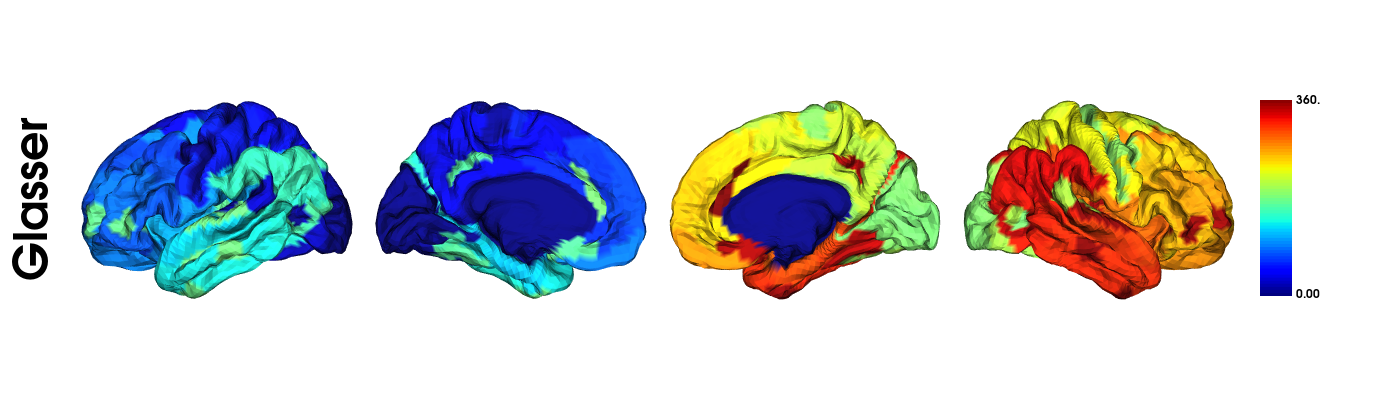

In [69]:
glasser = fetch_parcellation("fsaverage5", "glasser", 360)
plot_hemispheres(pial_left,pial_right,glasser, color_bar=True,
        label_text=["Glasser"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

In [183]:
glasser360_aires_list = ["EXT","L_V1","L_MST","L_V6","L_V2","L_V3","L_V4","L_V8","L_4","L_3b","L_FEF","L_PEF","L_55b","L_V3A","L_RSC","L_POS2","L_V7","L_IPS1","L_FFC","L_V3B","L_LO1","L_LO2","L_PIT","L_MT","L_A1","L_PSL","L_SFL","L_PCV","L_STV","L_7Pm","L_7m","L_POS1","L_23d","L_v23ab","L_d23ab","L_31pv","L_5m","L_5mv","L_23c","L_5L","L_24dd","L_24dv","L_7AL","L_SCEF","L_6ma","L_7Am","L_7PL","L_7PC","L_LIPv","L_VIP","L_MIP","L_1","L_2","L_3a","L_6d","L_6mp","L_6v","L_p24pr","L_33pr","L_a24pr","L_p32pr","L_a24","L_d32","L_8BM","L_p32","L_10r","L_47m","L_8Av","L_8Ad","L_9m","L_8BL","L_9p","L_10d","L_8C","L_44","L_45","L_47l","L_a47r","L_6r","L_IFJa","L_IFJp","L_IFSp","L_IFSa","L_p9-46v","L_46","L_a9-46v","L_9-46d","L_9a","L_10v","L_a10p","L_10pp","L_11l","L_13l","L_OFC","L_47s","L_LIPd","L_6a","L_i6-8","L_s6-8","L_43","L_OP4","L_OP1","L_OP2-3","L_52","L_RI","L_PFcm","L_PoI2","L_TA2","L_FOP4","L_MI","L_Pir","L_AVI","L_AAIC","L_FOP1","L_FOP3","L_FOP2","L_PFt","L_AIP","L_EC","L_PreS","L_H","L_ProS","L_PeEc","L_STGa","L_PBelt","L_A5","L_PHA1","L_PHA3","L_STSda","L_STSdp","L_STSvp","L_TGd","L_TE1a","L_TE1p","L_TE2a","L_TF","L_TE2p","L_PHT","L_PH","L_TPOJ1","L_TPOJ2","L_TPOJ3","L_DVT","L_PGp","L_IP2","L_IP1","L_IP0","L_PFop","L_PF","L_PFm","L_PGi","L_PGs","L_V6A","L_VMV1","L_VMV3","L_PHA2","L_V4t","L_FST","L_V3CD","L_LO3","L_VMV2","L_31pd","L_31a","L_VVC","L_25","L_s32","L_pOFC","L_PoI1","L_Ig","L_FOP5","L_p10p","L_p47r","L_TGv","L_MBelt","L_LBelt","L_A4","L_STSva","L_TE1m","L_PI","L_a32pr","L_p24","R_V1","R_MST","R_V6","R_V2","R_V3","R_V4","R_V8","R_4","R_3b","R_FEF","R_PEF","R_55b","R_V3A","R_RSC","R_POS2","R_V7","R_IPS1","R_FFC","R_V3B","R_LO1","R_LO2","R_PIT","R_MT","R_A1","R_PSL","R_SFL","R_PCV","R_STV","R_7Pm","R_7m","R_POS1","R_23d","R_v23ab","R_d23ab","R_31pv","R_5m","R_5mv","R_23c","R_5L","R_24dd","R_24dv","R_7AL","R_SCEF","R_6ma","R_7Am","R_7PL","R_7PC","R_LIPv","R_VIP","R_MIP","R_1","R_2","R_3a","R_6d","R_6mp","R_6v","R_p24pr","R_33pr","R_a24pr","R_p32pr","R_a24","R_d32","R_8BM","R_p32","R_10r","R_47m","R_8Av","R_8Ad","R_9m","R_8BL","R_9p","R_10d","R_8C","R_44","R_45","R_47l","R_a47r","R_6r","R_IFJa","R_IFJp","R_IFSp","R_IFSa","R_p9-46v","R_46","R_a9-46v","R_9-46d","R_9a","R_10v","R_a10p","R_10pp","R_11l","R_13l","R_OFC","R_47s","R_LIPd","R_6a","R_i6-8","R_s6-8","R_43","R_OP4","R_OP1","R_OP2-3","R_52","R_RI","R_PFcm","R_PoI2","R_TA2","R_FOP4","R_MI","R_Pir","R_AVI","R_AAIC","R_FOP1","R_FOP3","R_FOP2","R_PFt","R_AIP","R_EC","R_PreS","R_H","R_ProS","R_PeEc","R_STGa","R_PBelt","R_A5","R_PHA1","R_PHA3","R_STSda","R_STSdp","R_STSvp","R_TGd","R_TE1a","R_TE1p","R_TE2a","R_TF","R_TE2p","R_PHT","R_PH","R_TPOJ1","R_TPOJ2","R_TPOJ3","R_DVT","R_PGp","R_IP2","R_IP1","R_IP0","R_PFop","R_PF","R_PFm","R_PGi","R_PGs","R_V6A","R_VMV1","R_VMV3","R_PHA2","R_V4t","R_FST","R_V3CD","R_LO3","R_VMV2","R_31pd","R_31a","R_VVC","R_25","R_s32","R_pOFC","R_PoI1","R_Ig","R_FOP5","R_p10p","R_p47r","R_TGv","R_MBelt","R_LBelt","R_A4","R_STSva","R_TE1m","R_PI","R_a32pr","R_p24"]
indices = np.where(~np.isnan(cp[0]))
[glasser360_aires_list[i] for i in np.unique(glasser[indices])]

['L_10d', 'L_a47r', 'L_a9-46v', 'L_9-46d', 'L_9a', 'L_a10p', 'L_p10p']

In [186]:
#pour la surface, j'abandone l'idée de l'avoir en mm2 juste un nombre de vertex poru l'instant
print(np.unique(glasser[indices],return_counts=True))
print(pial_left.GetPolygons().shape,pial_left.GetPoints().shape)

(array([ 72,  77,  85,  86,  87,  89, 170], dtype=int32), array([ 6,  2, 13, 23, 14, 19, 22]))
(81920,) (10242, 3)


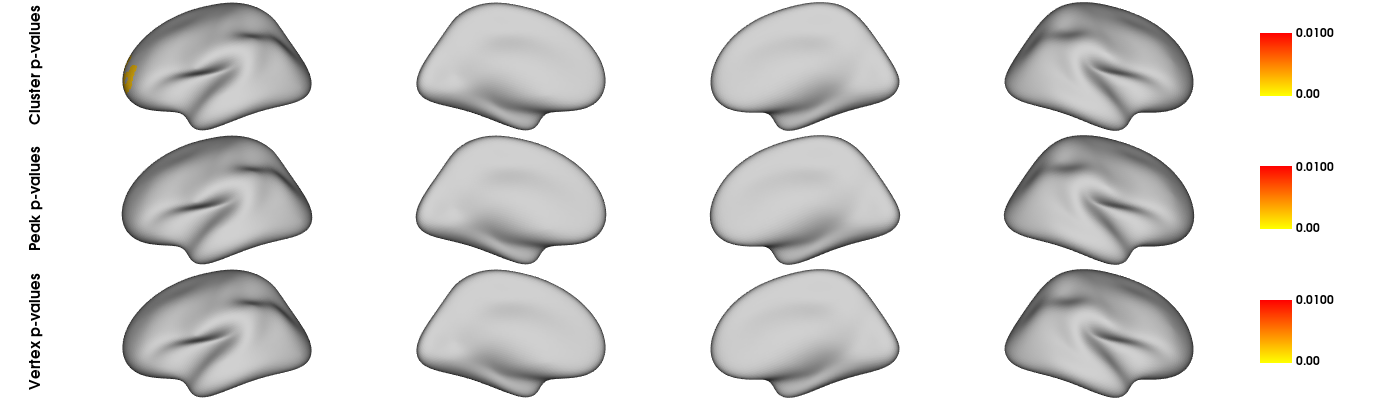

In [190]:
figure_title=os.path.join(STUDY_DIR,"results","corr_all_corrPAS_AwithBDI_inflated.png")

cp = [np.copy(slm_pas.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

pp = [np.copy(slm_pas.P["pval"]["P"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]

qp = [np.copy(slm_pas.Q)]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]

vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])

plot_hemispheres(fs5_lh, fs5_rh, vals, color_bar=True, color_range=(0, 0.01),
        label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"], cmap="autumn_r", 
        embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False,filename=figure_title)

In [201]:
term_bdi = FixedEffect(val_PD.BDI_tot)
model_bdi = term_bdi
term_pas = FixedEffect(val_PD.PAS_tot)
model_pas = term_pas

model_pasbdi= term_pas + term_bdi
contrast_pas = val_PD.PAS_tot
slm_pas = SLM(
    model_pasbdi,
    contrast_pas,
    surf="fsaverage5",
    mask=mask,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
)
slm_pas.fit(thickness_PD)

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/brainstat/stats/_t_test.py:51: UserWarning: Contrast is not in the model :-( 
  warnings.warn("Contrast is not in the model :-( ")


In [22]:
cp = [np.copy(slm_pas.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

figure_title=os.path.join(STUDY_DIR,"results","groupes_PDnonAnx_PDanx.png")

plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False,transparent_bg=False,screenshot=True, offscreen=True,filename=figure_title)

'/NAS/coolio/protocoles/Track_PD_DTA/results/groupes_PDnonAnx_PDanx.png'

cluster1


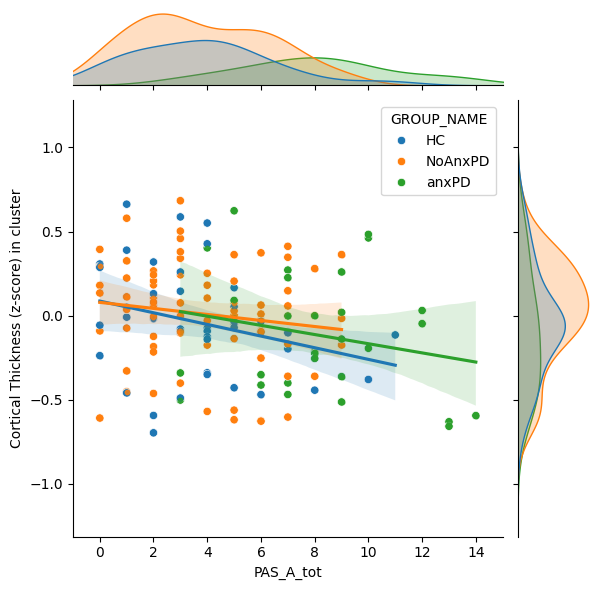

In [214]:
new_val=val
cpt=1
name="cluster"+str(cpt)
print(name)

#peaks=slm_grouppas.P["peak"][0][slm_grouppas.P["peak"][0]["clusid"]==cpt]["vertid"].values
#print(yeo_networks[peaks[0]])
inds=np.where(slm_pas.P['clusid'][1]==cpt)[1]
valCTperclust=np.mean(thickness[:,inds],1)
new_val[name]=valCTperclust
mediane = new_val[name].median()
iqr = new_val[name].quantile(0.75) - new_val[name].quantile(0.25)

#sns.jointplot(df,y="CorticalThickness",x="PAS_tot",kind="reg")
fig=sns.jointplot(new_val,y=name,x="PAS_A_tot",hue="GROUP_NAME")
plt.gca().set_xlim([-1, 15])
#plt.gca().set_ylim([1.7,2.8])
for diag in new_val["GROUP_NAME"].unique():
    sns.regplot(x="PAS_A_tot", y=name, data=new_val[new_val["GROUP_NAME"] == diag],scatter_kws={'s': 10})
    plt.gca().set_ylabel('Cortical Thickness (z-score) in cluster')  
    figure_title=os.path.join(STUDY_DIR,"results","corr_all_corrPAS_AwithBDI_cluster1.png")    
fig.savefig(os.path.join(STUDY_DIR,"results","corrplot_zscorethicknessVsPAS_A.png"))

In [212]:
import numpy as np
from scipy.stats import pearsonr

# Calculer le coefficient de corrélation (Pearson)
correlation_coefficient, p_val = pearsonr(new_val['PAS_A_tot'], new_val['cluster1'])

# Calculer le coefficient de détermination (R²)
r_squared = correlation_coefficient ** 2

print(f"Coefficient de corrélation (Pearson) : {correlation_coefficient} and p_value = {p_val}")
print("Coefficient de détermination (R²) :", r_squared)

Coefficient de corrélation (Pearson) : -0.2387012698996158 and p_value = 0.003713684187433985
Coefficient de détermination (R²) : 0.05697829625168922


In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

# Fit linear regression model
model = LinearRegression().fit(val['PAS_A_tot'].values.reshape(-1,1),val['cluster1'].values.reshape(-1,1))

# Compute explained variance
explained_variance = explained_variance_score(val['cluster1'].values.reshape(-1,1), model.predict(val['PAS_A_tot'].values.reshape(-1,1),))

print("Explained variance (R²):", explained_variance)

Explained variance (R²): 0.056978256435788244


(146, 1)

In [46]:
val['PAS_tot'].values.reshape(-1,1).shape

(146, 1)

In [105]:
slm_pas.P['clus'][1][0:1]

,clusid,nverts,resels,P
0,1,120.0,4.924215,0.000247


In [21]:
os.path.join(STUDY_DIR,"results","REGplot_PDnonAnx_PDanx.png")

'/NAS/coolio/protocoles/Track_PD_DTA/results/REGplot_PDnonAnx_PDanx.png'

In [106]:
slm_pas.P['peak'][1][slm_pas.P['peak'][1]['clusid']==1]

,t,vertid,clusid,P,yeo7
1,3.531056,25,1,1.667898,Limbic
2,3.388517,1465,1,2.475139,Default mode
4,3.330586,2810,1,2.894921,Default mode
10,3.067557,56,1,5.674636,Default mode
11,3.014069,1134,1,6.464032,Default mode
12,2.987422,8217,1,6.887720,Default mode


In [22]:
meta_analysis = meta_analytic_decoder("fsaverage5", cp[0].T.flatten())

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

2024-04-02 13:41:38,787 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2024-04-02 13:41:39,335 - brainstat - INFO - Running correlations with all Neurosynth features.


/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


ValueError: cannot convert float NaN to integer